#DSE203 - Assignment 2 - Group 5
Task -  Use TextRank to extract terms and use OpenAI to find relationships
<br>
Dataset used to test - usnewspaper_ tech.csv
<br>
Team members - Christopher, Vaaruni, Zufeshan

###Install dependencies

In [1]:
!pip install openai spacy pytextrank

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 1.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


###Set up OpenAI Api Key

In [2]:
#get OPENAI API key
from google.colab import userdata
api_key = userdata.get('openai')

###import dependencies

In [3]:
#import dependencies
import os
import openai
import pandas as pd
import spacy
import pytextrank
import re
import numpy as np
import json
import networkx as nx
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

###Load input data along with english vocabulary

In [4]:
#Load in data
docs = pd.read_csv('usnewspaper_tech.csv', header=None, sep=',')

#install english vocabulary
#spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm')

#add in textrank to pipeline
nlp.add_pipe("textrank")

###Preprocess text

In [5]:
#remove special characters from passages
def clean_text(text):
    return re.sub(r'[^\x00-\x7F]+','',text)

#Add in raw and cleaned text data to a new dataframe
new_docs = pd.DataFrame()
new_docs['RAW_TEXT'] = docs.iloc[:,0]

#remove NaNs and Nulls if any
new_docs.dropna(inplace=True)

#vectorize function
v = np.vectorize(clean_text)

#map to new column
new_docs['CLEAN_TEXT'] = v(new_docs['RAW_TEXT'])

#remove duplicates from text
new_docs = new_docs.drop_duplicates(subset=['CLEAN_TEXT'], keep='first')

len(new_docs)

6564

In [6]:
new_docs.head()

,RAW_TEXT,CLEAN_TEXT
0,"First Horizon Advisors Inc. trimmed its holdings in iShares Biotechnology ETF (NASDAQ:IBB – Get Rating) by 6.1% in the third quarter, according to the company in its most recent filing with the SE...","First Horizon Advisors Inc. trimmed its holdings in iShares Biotechnology ETF (NASDAQ:IBB Get Rating) by 6.1% in the third quarter, according to the company in its most recent filing with the SEC..."
1,Register for more free articles. Sign up for our newsletter to keep reading.\n\nBe the first to know Get local news delivered to your inbox! Sign up! Already a Subscriber? Already a Subscriber? Si...,Register for more free articles. Sign up for our newsletter to keep reading.\n\nBe the first to know Get local news delivered to your inbox! Sign up! Already a Subscriber? Already a Subscriber? Si...
2,"Business Today: the best news, analysis and comment from The Irish Times business desk","Business Today: the best news, analysis and comment from The Irish Times business desk"
3,Cookie Preferences Cookie List\n\nCookie List\n\nA cookie is a small piece of data (text file) that a website – when visited by a user – asks your browser to store on your device in order to remem...,Cookie Preferences Cookie List\n\nCookie List\n\nA cookie is a small piece of data (text file) that a website when visited by a user asks your browser to store on your device in order to remembe...
4,"Fintech StellarFi, which helps people improve their credit score, just raised $15 million.\n\nThe startup pools customer debts, repays them on time, and reports them to credit bureaus.\n\nCheck ou...","Fintech StellarFi, which helps people improve their credit score, just raised $15 million.\n\nThe startup pools customer debts, repays them on time, and reports them to credit bureaus.\n\nCheck ou..."


###Extract keywords with rank more than 0.12 from all passages
rank threshold is set to 0.12 to limit the no. of keywords generated per passage for a concise and accurate KG.

In [7]:
def extract_keywords(passage):
    keywords = []
    doc = nlp(passage)
    keywords = [k.text for k in doc._.phrases if k.rank > 0.12]
    return keywords


###Given the input dataframe, input text and index, function **extract_relations_and_draw_KG** extracts keywords, checks for rows with a single or zero keywords, invokes openai's gpt3.5-turbo api to extract relations among multiple entities. It then creates DataFrame with entities and relations to finally generate KG using networkx.

In [38]:
def extract_relations_and_draw_KG(idx, input_df, input_col):
  relations = []
  #extract_keywords using TextRank
  entity_list = extract_keywords(input_df[input_col][idx])
  if len(entity_list)<=1:
    print("Not enough keywords to create a graph")
    return 0
  else:
    #setup API key
    openai.api_key = api_key

    #select passage from input csv
    passage = input_df[input_col][idx]

    #specify a concise and accurate prompt to Openai API
    prompt = """ Given the following passage and phrases, extract the relationships as verbs and prepositions between the phrases
    while STRICTLY following these rules
    1. relation must be accurate and must NOT be more than 50 characters. If you cannot find any information on the entities and
    relationships above, it is okay to return empty value.
    2. Do NOT create fictious data.
    3. Never impute missing values
    4. The output content should be in json format
    5. If you will be unable to fit a full relationship pairing from one entity to another entity within the token limit,
    please DO NOT include that entry in the response """

    #call gpt-3.5-turbo to extract relations
    response = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        messages=[
        {"role": "system", "content": "You are a helpful assistant that extracts relationships that connects multiple entities."},
        {"role": "user", "content": f"{prompt}, passage:{passage}, phrases: {entity_list}"}
        ],
        temperature=0,
        max_tokens=1024 )
    #get the response
    res = response.choices[0]["message"]["content"]
    result = json.loads(res)

    #create dataframe from the json output
    df = pd.DataFrame(result["relationships"])
    print(df)

    #draw KG using networkx
    G=nx.from_pandas_edgelist(df, "entity1", "entity2",
                              edge_attr=True, create_using=nx.MultiDiGraph())

    plt.figure(figsize=(6,6))
    pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
    nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
    plt.show()

###Invoke extract_relations_and_draw_KG for idx = 2

                         entity1 relation                        entity2
0  The Irish Times business desk     from  Business Today: the best news
1  The Irish Times business desk  comment                       analysis
2  The Irish Times business desk     from                The Irish Times


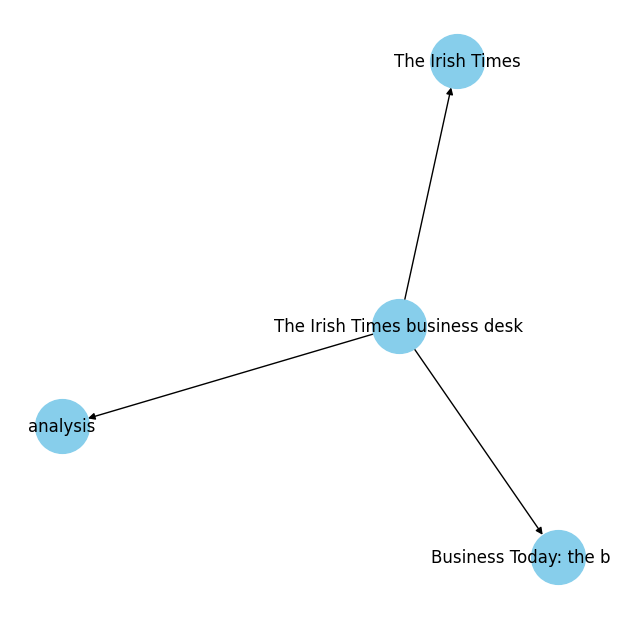

In [39]:
extract_relations_and_draw_KG(2, new_docs, 'CLEAN_TEXT')

###Invoke extract_relations_and_draw_KG for idx = 8

                  entity1 relationship                         entity2
0          Best Buy sales        offer                 major discounts
1     Best Buy tech deals      provide                   awesome deals
2   Best Buy laptop deals        offer                       discounts
3       Best Buy TV deals      provide                       discounts
4                Best Buy       launch  My Best Buy membership program
5                Best Buy         earn                      commission
6         Best Buy tablet      upgrade                     tablet tech
7       Featured Best Buy         save                         $164.01
8  Best Buy`s daily deals      include               top-rated devices


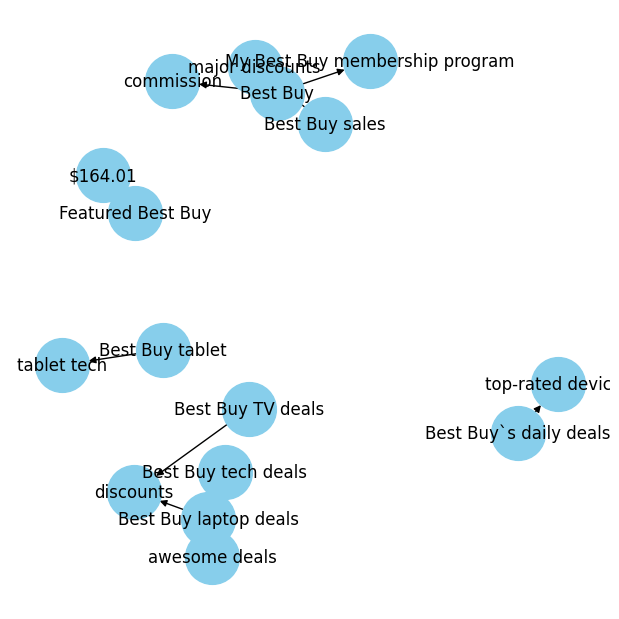

In [40]:
extract_relations_and_draw_KG(8, new_docs, 'CLEAN_TEXT')